# Parte III: RandomForest

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt


In [2]:
# Do not print warings
import warnings; warnings.simplefilter('ignore')

In [3]:
RANDOM_STATE = 24 #mi numero favoritos
N_JOBS = -1

prefix = {
    "NF":"|",
    "B": "BINARY_ENCODING|",
    "TFIDF":"TFIDF|",
    "ME":"MEAN_ENCODING|",
    "OHE":"ONE_HOT_ENCODING|"    
}

## Obtengo el dataset

Uno dos de los archivos con datos otorgados

In [4]:
df_identity = pd.read_csv("dataset/train_identity.csv")
df_transaction = pd.read_csv("dataset/train_transaction.csv")

In [5]:
df_train = df_identity.merge(df_transaction, on="TransactionID", how="outer")
df_identity, df_transaction = None, None #libero memoria

In [6]:
len_rows , len_columns = df_train.shape

## Identifico columas unicas

Observamos que la única columna con valores únicos es la que representa "TransactionID".

In [7]:
(df_train.nunique() == len_rows).value_counts()

False    433
True       1
dtype: int64

## Elimino columnas vacias 

Observo que no hay columnas vacias

In [8]:
(df_train.isna().sum() == len_rows).value_counts()

False    434
dtype: int64

### Identifico variables categoricas

In [9]:
FEATURES_CATEGORICOS = list(df_train.dtypes[(df_train.dtypes =="object")].index)

## Feature engineering

### Funciones auxiliares

In [10]:
def binary_encoding(value, keys):
    if(value==keys[0]):
        return 1
    elif(value==keys[1]):
        return 0
    return np.nan

In [11]:
def mean_encoding(df, feature_name, target_name):
    values = df.groupby([feature_name])[target_name].mean().to_dict()
    return df[feature_name].map(values)

def mean_encoding_test(df, df_train, feature_name, target_name):
    values = df_train.groupby([feature_name])[target_name].mean().to_dict()
    return df[feature_name].map(values)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_encoding(df, feature_name, min_df=0.01, df_test= None, isTest = False):
    train = df[feature_name].fillna("")
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english', min_df=min_df)
    tfidf_wm = tfidfvectorizer.fit_transform(train)
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    if(isTest):
        test = df_test[feature_name].fillna("")
        tfidf_wm = tfidfvectorizer.transform(test)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), columns = tfidf_tokens)
    df_tfidfvect.columns = [prefix["NF"] + prefix["TFIDF"] + x for x in df_tfidfvect.columns]
    return df_tfidfvect

In [13]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, feature_name, df_test= None, isTest = False):
    enc = OneHotEncoder(handle_unknown='ignore')
    
    train = df[[feature_name]]
    enc_wm = enc.fit(train)
    enc_tokens = enc.get_feature_names()
    if(isTest):
        test = df_test[[feature_name]].fillna("")
        enc_data = enc.transform(test)
    else:
        enc_data = enc.transform(train)

    df_enc = pd.DataFrame(data = enc_data.toarray(), columns = enc_tokens)
    df_enc.columns = [prefix["NF"] + prefix["OHE"] + x for x in df_enc.columns]
    return df_enc

### Casos particulares

In [14]:
def get_match_status(x):
    if(type(x) != float):
        return int(x.split(":")[1])
    return np.nan

def enconde_id_34(df):
    df[prefix["NF"] + "id_34"] = df["id_34"].apply(lambda x: get_match_status(x))

In [15]:
def get_size_screen(x):
    if(type(x) != float):
        return int(x.split("x")[1])
    return np.nan

def enconde_id_33(df):
    temp =  df["id_33"].apply(lambda x: get_size_screen(x))
    df[prefix["NF"] + "1|" + "id_33"] = temp.apply(lambda x: x[0] if(type(x) != float) else np.nan)
    df[prefix["NF"] + "2|" + "id_33"] = temp.apply(lambda x: x[1] if(type(x) != float) else np.nan)
        

### Feature engineering

In [16]:
features_one_hot_encoding = ["id_15", "id_23", "id_34", "DeviceType", "ProductCD", "card4", "card6", "M4"]

In [17]:
def feature_engineering(df_original, df_train = None, isTest=False, allowCategorical= True):
    
    df = df_original.copy()
    
    # Features unicos
    features_unicas = []
    for feature in features_unicas:
        del df[feature]
        
    # Mean encoding
    feature_mean_encoding = [
        'id_15', 'id_23', 'id_30','id_31', 'id_33', 'id_34', 'DeviceInfo', 'ProductCD', 'card4', 'card6',
       'P_emaildomain', 'R_emaildomain', 'M4']
    
    for feature in feature_mean_encoding:
        if(isTest):
            df[prefix["NF"] + prefix["ME"] + feature] = mean_encoding_test(df, df_train, feature, "isFraud")
        else:
            df[prefix["NF"] + prefix["ME"] + feature] = mean_encoding(df, feature, "isFraud")
    
    # TFIDF
    features_tdf_idf = ['id_23', 'id_30','id_31', 'id_33', 'DeviceInfo', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4']
        
    for feature in features_tdf_idf:        
        if(isTest):
            df.join(tfidf_encoding(df, feature, 0.001, df_original, isTest))
        else:
            df.join(tfidf_encoding(df, feature, min_df=0.001))

    # One hot encoding
    lista_features_binarias = ["id_35", "id_36", "id_37", "id_38",
                               'M1', 'M2', 'M3', "M5", "M6", 'M7', 'M8', 'M9',
                               "id_12", "id_27", "id_28", "id_29","id_16",
                               'DeviceType']
    features_one_hot_ecoding = lista_features_binarias + ["id_15", "id_23", "id_34", "DeviceType", "ProductCD", "card4", "card6", "M4"]
    for feature in features_one_hot_ecoding:        
        if(isTest):
            df.join(one_hot_encoding(df, feature, df_original, isTest))
        else:
            df.join(one_hot_encoding(df, feature))
            
    # Casos particulares
    enconde_id_34(df)
    enconde_id_33(df)
    
    #Puede tener features categoricos
    if(not allowCategorical):
        for i in FEATURES_CATEGORICOS:
            del df[i]
            
    return df

## RandomForestClassifier

In [18]:
# Librerias

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Se separa el target

df_RF = feature_engineering(df_train, allowCategorical=False).fillna(0)

X = df_RF.drop(columns = ["isFraud"])
del X["TransactionID"]

y = df_RF["isFraud"]

df_RF = None

### Corrida básica sin tunning

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

clf = RandomForestClassifier(n_jobs=N_JOBS).fit(X_train, y_train)

In [22]:
roc_auc_score(clf.predict(X_test), y_test)

0.9625159729758355

### Mejor score de validación

En esta sección se calculará el mejor score de validación obtenido.

Para ello, se emplea Cross Validation y tunning de hieprparametros para obtener el mejor resultado.

In [23]:
space = {
    'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "criterion": ["gini", "entropy"],
    'n_estimators': [10,20,50,80,100,150,250,400,500,800,1000],
    'max_features': ['auto', "sqrt", "log2"],
    'min_samples_split': np.arange(0, 15, 1),
    'min_samples_leaf': np.arange(0, 15, 1),
    "min_impurity_decrease": [0.00001,0.0001, 0.0005, 0.001, 0.01],
    "min_weight_fraction_leaf": [0.00001,0.0001, 0.0005, 0.001, 0.01]
}

In [24]:
model = RandomForestClassifier(n_jobs=N_JOBS)

cv = KFold(n_splits=3)

search = RandomizedSearchCV(model,
                            space,
                            cv=cv,
                            scoring='roc_auc',
                            random_state=RANDOM_STATE,
                            n_jobs=N_JOBS)

result = search.fit(X, y)

# summarize result:

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8309784245219363
Best Hyperparameters: {'n_estimators': 500, 'min_weight_fraction_leaf': 0.0005, 'min_samples_split': 9, 'min_samples_leaf': 1, 'min_impurity_decrease': 1e-05, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}


### Predicción en la compentecia

En la siguiente sección vamos a calcular la predicció si estuvieramos compitiendo con el mejor modelo que se logró con el modelo "Logistic Regression".

In [25]:
# Leo archivos test

df_identity_test = pd.read_csv("dataset/test_identity.csv")
df_transaction_test = pd.read_csv("dataset/test_transaction.csv")

df_test = df_identity_test.merge(df_transaction_test, on="TransactionID", how="outer")
df_identity_test, df_transaction_test = None, None

In [26]:
# Aplico Feature Engineering

df_test.columns = df_test.columns.str.replace("id-", "id_")
X_test = feature_engineering(df_test, df_train, True, allowCategorical=False).fillna(0)
TransactionID = X_test["TransactionID"]
del X_test["TransactionID"]

In [27]:
# Creo modelo con los hiperparametros resultantes de la busqueda de hiperparametros

best_RF_params = {'n_estimators': 500, 'min_weight_fraction_leaf': 0.0005, 'min_samples_split': 9, 'min_samples_leaf': 1, 'min_impurity_decrease': 1e-05, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': False}
best_RF = RandomForestClassifier(**best_RF_params)
best_RF.fit(X, y)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=30,
                       max_features='sqrt', min_impurity_decrease=1e-05,
                       min_samples_split=9, min_weight_fraction_leaf=0.0005,
                       n_estimators=500)

In [29]:
# Creo archivo para realizar el submit en la competencia

result_competition = best_RF.predict_proba(X_test)
result = pd.DataFrame()

result["TransactionID"] = TransactionID
result["isFraud"] = result_competition[:, 1]

In [30]:
result.to_csv('predictions/RF_2021-11-26-21:01' + '.csv', index=False)

En la competencia se logro un puntaje de 0.883026 (private) y 0.899807 (public).

### Mejores features

In [31]:
# Creo un dataframe con la importancia de cada feature

df_features_coef = pd.DataFrame()
df_features_coef["feature"] = X_test.columns
df_features_coef["importance"] = abs(best_RF.feature_importances_)
df_features_coef.set_index(["feature"], inplace=True)

In [32]:
# Busco los n features mas importantes

n = 30
top_n = df_features_coef["importance"].nlargest(n)

top_n

feature
V258                         0.029875
V201                         0.027126
C13                          0.027101
C14                          0.026957
C1                           0.021368
V257                         0.018995
V200                         0.018937
|MEAN_ENCODING|DeviceInfo    0.018518
V244                         0.017405
V246                         0.016795
V243                         0.015300
C4                           0.015229
V317                         0.014370
C8                           0.014222
V187                         0.013041
V189                         0.013023
V199                         0.012813
C12                          0.012582
C7                           0.011818
C11                          0.011551
V242                         0.011405
V294                         0.011100
V190                         0.011080
V274                         0.010578
C10                          0.010225
V295                         0.010078
V318

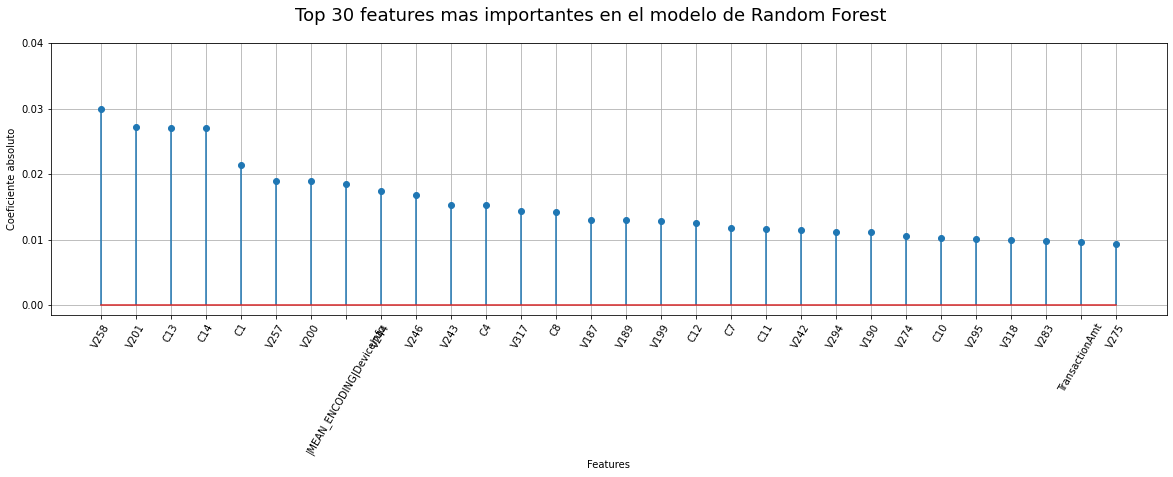

In [34]:
# Grafico los n features mas importantes

fig, axs = plt.subplots(figsize=(20,5))

plt.stem(top_n)
plt.xticks(range(n),top_n.index, rotation=60)
plt.yticks(np.arange(0,0.05,0.01))
plt.grid(True)
plt.xlabel("Features")
plt.ylabel("Coeficiente absoluto")

fig.suptitle("Top 30 features mas importantes en el modelo de Random Forest", fontsize=18)

plt.show()